In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.style.use('science')

import numpy as np
import sys; sys.path.insert(0, "../"); from utils import *

Running Python 3.9.7
You can use npar for np.array


In [8]:
eq_name = "Burgers' PDE: 3000 labels, $\lambda_{1}=10^{-1}$"
feature_names = ["u", "u_{x}", "u_{xx}", "u_{xxx}"]
feature_names = ['$'+e+'$' for e in feature_names]
feature_importance = [0.2735, 0.1883, 0.2060, 0.2133]
feature_importance = npar(feature_importance)

In [9]:
def plot_feature_importance_neural_net(feature_importances, feature_names, eq_name=eq_name, save_path=None):
    threshold = 1/len(feature_names)
    
    # split it up
    above_threshold = np.maximum(feature_importance - threshold, 0)
    below_threshold = np.minimum(feature_importance, threshold)

    # and plot it
    fig, ax = plt.subplots()
    ax.bar(feature_names, below_threshold, 0.35, color="g")
    ax.bar(feature_names, above_threshold, 0.35, color="r", bottom=below_threshold)
    
    # horizontal line indicating the threshold
    ax.plot([-0.175, len(feature_names)*0.8], [threshold, threshold], "k--")
    plt.title(eq_name)
    plt.xlabel("Partial derivative candidates\n$[u_t = -0.924525uu_{x}+0.002695u_{xx}]$")
    plt.ylabel("Feature importance")
    
    if save_path is not None: fig.savefig(save_path, dpi=300)

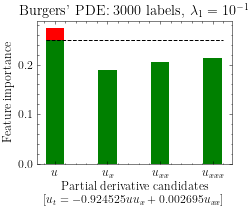

In [10]:
save_path = "./hyperparameter_study/lambda/1e-1.png"
with plt.style.context(['science']):
    plot_feature_importance_neural_net(feature_importance, feature_names, eq_name, save_path=save_path)

In [5]:
# !rm './tmp.jpg'

In [6]:
# No selector network (Not the same as setting lambda_1 to 0.0) 
# PDE derived using STRidge
# u_t = (0.002543 +0.000000i)u_xx
#     + (-0.832252 +0.000000i)uf*u_x

# 1e-1
# tensor([0.2735, 0.1883, 0.2060, 0.2133])
# u_t = (0.002695 +0.000000i)u_xx
#     + (-0.924525 +0.000000i)uf*u_x

# 1e-3
# tensor([0.8153, 0.8142, 0.4398, 0.1562])
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x

# 1e-5
# tensor([0.6721, 0.7903, 0.7139, 0.3486])
# u_t = (0.002594 +0.000000i)u_xx
#     + (-0.885143 +0.000000i)uf*u_x

In [7]:
# Goals!!!
# 3000 | eq found by STR | eq after PINN fine-tuning + mean error
# 1000 | eq found by STR | eq after PINN fine-tuning + mean error
# 500 | eq found by STR | eq after PINN fine-tuning + mean error

# 3000
# eq found by STR 
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x
# eq after PINN fine-tuning + mean error
# (-0.9994307160377502, 0.0031862353649783444)
# (0.07773227423228249, )

# 1000
# eq found by STR
# u_t = (0.002631 +0.000000i)u_xx
#     + (-0.860374 +0.000000i)uf*u_x
# eq after PINN fine-tuning + mean error
# (-0.9891335368156433, 0.0031485233921557665)
# (1.0864333669569826, 0.0002129514786863851)

# 500
# eq found by STR (failed)
# u_t = (-0.072116 +0.000000i)uf*u_x

In [8]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.style.use('science')

# always import gbm_algos first !
import xgboost, lightgbm, catboost

# Core
import numpy as np
import scipy.io as io
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset

# Sklearn
from sklearn.ensemble import RandomForestRegressor
from mlens.ensemble import SuperLearner

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew
# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder
from onecyclelr import OneCycleLR
import pcgrad
from pytorch_stats_loss import torch_wasserstein_loss, torch_energy_loss
from geomloss import SamplesLoss
from utils import *

from tqdm import trange

from pde_diff import *
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['save', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


[MLENS] backend: threading


In [9]:
DATA_PATH = "../experimental_data/burgers_shock.mat"
data = io.loadmat(DATA_PATH)

t = data['t'].flatten()[:,None]; dt = t[1]-t[0]; nt = len(t)
x = data['x'].flatten()[:,None]; dx = x[1]-x[0]; nx = len(x)
u = np.real(data['usol'])
Exact = u.T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

<ipython-input-19-44ec68fae5da>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig1.gca(projection='3d')


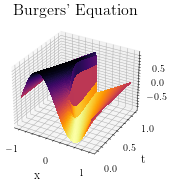

In [19]:
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.inferno_r, linewidth=0, antialiased=False)
title("Burgers' Equation", fontsize = 16)
xlabel('x', fontsize = 12)
ylabel('t', fontsize = 12)
plt.savefig("./burgers/ground.png", dpi=300)
plt.show()